# Here we implement LDA Topic Modeling

In [1]:
# imports
# Parsing Imports
import bs4 as bs
import urllib.request
import re
import string

# data and processing
import wikipedia
import nltk
import re
from nltk.stem import WordNetLemmatizer



# NPL imports
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

from sklearn.datasets import fetch_20newsgroups

# visualization
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis

import matplotlib.pyplot as plt
import seaborn as sns

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

### *Scraping*

In [2]:
# nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

global_warming = wikipedia.page("Warming")
artificial_intelligence = wikipedia.page("Artificial Intelligence")
mona_lisa = wikipedia.page("Mona Lisa")
eiffel_tower = wikipedia.page("Eiffel Tower")

racing = wikipedia.page("Horse Racing")
music = wikipedia.page(pageid=931)
art = wikipedia.page(pageid=752)
comedy = wikipedia.page("Comedy")

film = wikipedia.page("Film")
physics = wikipedia.page(pageid=22939)
alaska = wikipedia.page("Alaska")
covid = wikipedia.page("COVID-19")

corpus = [global_warming.content, artificial_intelligence.content, mona_lisa.content, 
          eiffel_tower.content, racing.content, music.content, art.content, comedy.content, 
          film.content, physics.content, alaska.content, covid.content, ]

### *Pre-Processing, vectorization and Lemmarization*

In [3]:
stemmer = WordNetLemmatizer()

In [4]:
def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word)  > 5]

        return tokens

In [5]:
# nltk.download('wordnet')

processed_data = [];
for doc in corpus:
    tokens = preprocess_text(doc)
    processed_data.append(tokens)
    
print("Shape : ", len(processed_data), len(processed_data[0]))
print(processed_data)

Shape :  12 3786
[['climate', 'change', 'includes', 'global', 'warming', 'driven', 'induced', 'emission', 'greenhouse', 'resulting', 'weather', 'pattern', 'though', 'previous', 'period', 'climatic', 'change', 'century', 'unprecedented', 'impact', 'climate', 'system', 'caused', 'change', 'global', 'largest', 'driver', 'warming', 'emission', 'create', 'greenhouse', 'effect', 'carbon', 'dioxide', 'methane', 'fossil', 'burning', 'natural', 'energy', 'consumption', 'source', 'emission', 'additional', 'contribution', 'agriculture', 'deforestation', 'manufacturing', 'climate', 'change', 'disputed', 'scientific', 'national', 'international', 'standing', 'temperature', 'accelerated', 'tempered', 'climate', 'feedback', 'sunlight', 'reflecting', 'increased', 'vapour', 'greenhouse', 'change', 'carbon', 'temperature', 'global', 'average', 'increase', 'leading', 'desert', 'expansion', 'common', 'wildfire', 'temperature', 'amplified', 'arctic', 'contributed', 'melting', 'permafrost', 'glacial', 'retr

In [6]:
# Loading data
data = processed_data

### *Vectorization*

In [7]:
# creating dictionary to keep unique tokens
dictionary = corpora.Dictionary(data)

print(dictionary)
print(len(dictionary))
print("Eamples : ", dictionary[10], dictionary[100], dictionary[1000])

Dictionary(7695 unique tokens: ['ability', 'abrupt', 'absence', 'absorb', 'absorbed']...)
7695
Eamples :  acceded attempt responsible


In [8]:
# document trem matrix row=doc col=word (dimention : num_words x len_dict) 
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data]

print("Shape : ", len(doc_term_matrix), len(doc_term_matrix[0]))
print(doc_term_matrix)

Shape :  12 1280
[[(0, 1), (1, 2), (2, 1), (3, 4), (4, 4), (5, 2), (6, 2), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 4), (22, 1), (23, 1), (24, 1), (25, 6), (26, 8), (27, 1), (28, 5), (29, 2), (30, 1), (31, 17), (32, 2), (33, 2), (34, 7), (35, 8), (36, 1), (37, 1), (38, 1), (39, 1), (40, 14), (41, 7), (42, 4), (43, 5), (44, 1), (45, 1), (46, 1), (47, 1), (48, 13), (49, 5), (50, 8), (51, 5), (52, 1), (53, 1), (54, 3), (55, 4), (56, 4), (57, 4), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 14), (67, 2), (68, 1), (69, 1), (70, 1), (71, 3), (72, 1), (73, 2), (74, 4), (75, 1), (76, 2), (77, 1), (78, 1), (79, 6), (80, 1), (81, 3), (82, 1), (83, 1), (84, 13), (85, 1), (86, 1), (87, 5), (88, 1), (89, 2), (90, 1), (91, 2), (92, 1), (93, 4), (94, 1), (95, 1), (96, 3), (97, 2), (98, 23), (99, 10), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 2), (108

### *LDA Model*

In [9]:
# creating LDA object using gensim
LDA = gensim.models.ldamodel.LdaModel

# Bilding LDA object
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100, chunksize=1000, passes=100, iterations=100)

In [10]:
# printing all the topics fetched
lda_topics = lda_model.print_topics()

for topic, i in zip(lda_topics, range(len(lda_topics))):
    print("Topic", i+1, ":", topic[1][:140])

Topic 1 : 0.029*"eiffel" + 0.008*"second" + 0.007*"french" + 0.006*"exposition" + 0.006*"structure" + 0.005*"tallest" + 0.005*"engineer" + 0.005*"desi
Topic 2 : 0.018*"climate" + 0.013*"change" + 0.009*"warming" + 0.008*"emission" + 0.008*"people" + 0.008*"disease" + 0.007*"global" + 0.007*"infection
Topic 3 : 0.061*"alaska" + 0.008*"anchorage" + 0.007*"united" + 0.007*"largest" + 0.007*"population" + 0.006*"alaskan" + 0.006*"native" + 0.006*"ameri
Topic 4 : 0.008*"artist" + 0.008*"century" + 0.007*"aesthetic" + 0.005*"object" + 0.005*"painting" + 0.005*"culture" + 0.005*"example" + 0.004*"histor
Topic 5 : 0.039*"physic" + 0.013*"theory" + 0.008*"matter" + 0.008*"mechanic" + 0.008*"company" + 0.008*"electric" + 0.008*"particle" + 0.007*"edison"
Topic 6 : 0.000*"physic" + 0.000*"spider" + 0.000*"theory" + 0.000*"century" + 0.000*"example" + 0.000*"picture" + 0.000*"amazing" + 0.000*"system" + 
Topic 7 : 0.027*"racing" + 0.007*"production" + 0.007*"thoroughbred" + 0.006*"industry" + 0.00

### *Visualization using pyLDAvis*

In [11]:
# visualizig optimal model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary, mds='mmds')

# printing model
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.262144  0.063123       1        1  23.041384
9      0.119807  0.181791       2        1  17.458762
6     -0.219253  0.035698       3        1  15.636042
2     -0.155937  0.220859       4        1  11.990607
4      0.183968 -0.142254       5        1   9.765778
3     -0.012887  0.129074       6        1   9.639565
8     -0.042892 -0.283689       7        1   6.375698
0     -0.153281 -0.120197       8        1   6.085119
5      0.009166 -0.042203       9        1   0.003522
7      0.009167 -0.042203      10        1   0.003522, topic_info=          Term        Freq       Total Category  logprob  loglift
4740    spider  205.000000  205.000000  Default  30.0000  30.0000
6462    alaska  252.000000  252.000000  Default  29.0000  29.0000
2092    physic  131.000000  131.000000  Default  28.0000  28.0000
4187    racing  145.000000  145.000000  Default  27.0000  27.0000
4406   amazing   90.000000   90.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
2859    museum    0.000156   25.984649  Topic10  -8.9483  -1.7697
4187    racing    0.000156  145.738211  Topic10  -8.9483  -3.4940
57    although    0.000156   37.377539  Topic10  -8.9483  -2.1332
81    approach    0.000156   40.106053  Topic10  -8.9483  -2.2037
120     become    0.000156   32.459523  Topic10  -8.9483  -1.9921

[603 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3124      8  0.719556  0236400363
0         1  0.134893     ability
0         2  0.449644     ability
0         3  0.134893     ability
0         5  0.044964     ability
...     ...       ...         ...
2492      7  0.742563      writer
2492      8  0.099008      writer
4345      1  0.055121     zealand
4345      3  0.881936     zealand
4345      4  0.055121     zealand

[1266 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 7, 3, 5, 4, 9, 1, 6, 8])

### *Metrics for Mesuring the Quality of Topic Modeling*

Here we use 2 differtent metrics called `Perplexity` and `Coherence`.<br>
The Model is considered good when Perplexity is as __LOW__ as Possible ans Coherence is as __HIGH__ as Possible.

In [12]:
print("Perplexity : ", lda_model.log_perplexity(doc_term_matrix, total_docs=10000))

# computing Coherence
coherennce_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')

print("Coherence : ", coherennce_model_lda.get_coherence())

Perplexity :  -7.173848761363221
Coherence :  0.5025323602680617


### *Finding Optimal Number of Topics*

In [13]:
def compute_coherence_value(dictionary, corpus, texts, limit, start=2, steps=3):
    """
    compute c_v coherence for various number of topics
    
    Parameters :
    -----------
    dictionary : Gensim Dictionary
    corpus : Gensim Corpus
    texts : List of input Texts
    limit : Max Number of Topics

    Returns :
    -----------
    model_list : 
    coherence_values : 
    """
    
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, steps):
        model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# executing model
model_list, coherence_values = compute_coherence_value(dictionary=dictionary, corpus=doc_term_matrix, texts=data, start=2, limit=50, steps=3)

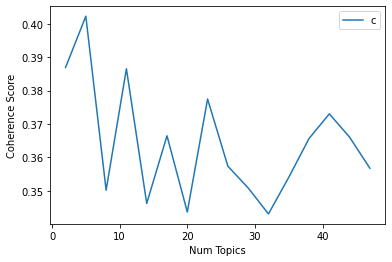

In [15]:
# %matplotlib notebook
%matplotlib inline
# plotting graph
limit = 50 
start=2 
step=3

x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")

plt.legend(("coherence_values"), loc='best')

plt.show()

In [16]:
# printig coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics : ", m, "Coherence Value : ", round(cv, 4))

Num Topics :  2 Coherence Value :  0.3869
Num Topics :  5 Coherence Value :  0.4022
Num Topics :  8 Coherence Value :  0.3502
Num Topics :  11 Coherence Value :  0.3865
Num Topics :  14 Coherence Value :  0.3462
Num Topics :  17 Coherence Value :  0.3665
Num Topics :  20 Coherence Value :  0.3437
Num Topics :  23 Coherence Value :  0.3775
Num Topics :  26 Coherence Value :  0.3574
Num Topics :  29 Coherence Value :  0.3509
Num Topics :  32 Coherence Value :  0.3431
Num Topics :  35 Coherence Value :  0.354
Num Topics :  38 Coherence Value :  0.3657
Num Topics :  41 Coherence Value :  0.373
Num Topics :  44 Coherence Value :  0.366
Num Topics :  47 Coherence Value :  0.3568


### *Final Optimal Selected Model*

In [17]:
# selecting optimal model
# NOTE : Actual application may require further processed data
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics()
print(model_topics)

# printing all the topics fetched
optimal_topics = lda_model.print_topics()

for topic, i in zip(lda_topics, range(len(lda_topics))):
    print("Topic", i+1, ":", topic[1][:140])


[(0, [('alaska', 0.017471101), ('racing', 0.010393688), ('united', 0.0042643105), ('american', 0.003465611), ('people', 0.0032275866), ('system', 0.0031627624), ('climate', 0.0029369355), ('national', 0.002805408), ('century', 0.002738969), ('thoroughbred', 0.0027027884)]), (1, [('climate', 0.010177382), ('change', 0.0076291794), ('warming', 0.0049383254), ('painting', 0.0046818843), ('century', 0.004540306), ('global', 0.0042798775), ('physic', 0.0041977013), ('emission', 0.0038028033), ('spider', 0.0034065933), ('system', 0.0033206246)]), (2, [('spider', 0.011465182), ('alaska', 0.011135787), ('physic', 0.007006059), ('amazing', 0.004881789), ('racing', 0.0037581662), ('people', 0.0036348803), ('system', 0.003492478), ('climate', 0.0032929867), ('company', 0.0029950095), ('change', 0.0027298962)]), (3, [('intelligence', 0.0049382104), ('painting', 0.004215025), ('system', 0.0040141637), ('artificial', 0.003975261), ('racing', 0.003913855), ('research', 0.003880415), ('machine', 0.003

In [18]:
# visualizig optimal model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)

# printing model
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.007913  0.004923       1        1  29.284321
1      0.020742  0.016642       2        1  22.693908
0     -0.036253  0.006401       3        1  20.175488
4      0.017825 -0.015618       4        1  18.305372
2     -0.010227 -0.012349       5        1   9.540911, topic_info=             Term        Freq       Total Category  logprob  loglift
6462       alaska  211.000000  211.000000  Default  30.0000  30.0000
4740       spider  189.000000  189.000000  Default  29.0000  29.0000
4187       racing  135.000000  135.000000  Default  28.0000  28.0000
4406      amazing   86.000000   86.000000  Default  27.0000  27.0000
176       climate  141.000000  141.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
991      research    6.624591   89.161876   Topic5  -6.1958  -0.2501
2880     painting    6.662556  108.853717   Topic5  -6.1901  -0.4439
1042       series    5.189638   43.560533   Topic5  -6.4399   0.2221
326   development    5.218172   49.158228   Topic5  -6.4344   0.1067
64       american    5.218597   51.521174   Topic5  -6.4344   0.0598

[356 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.469008  ability
0         2  0.170548  ability
0         3  0.127911  ability
0         4  0.170548  ability
0         5  0.042637  ability
...     ...       ...      ...
4345      1  0.185169  zealand
4345      2  0.123446  zealand
4345      3  0.493784  zealand
4345      4  0.061723  zealand
4345      5  0.123446  zealand

[1077 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 3])